## Noise Conditional Score Network (NCSN)

In [10]:
import os
import cv2
import numpy as np 
from tqdm import tqdm
from PIL import Image
from glob import glob
import warnings

from easydict import EasyDict
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torchvision.datasets import CelebA
from torchvision import transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image, make_grid

from model import CondRefineNetDilated

warnings.filterwarnings('ignore')

## Hyperparameters

In [11]:
config = EasyDict({
    'data_root': '/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/',
    'batch_size': 128,
    'n_iters' : 200001, # Total iterations
    'n_epochs' : 500000, 
    'epsilon' : 1.5e-5, # 0.000015
    'learning_rate' : 0.001,
    
    'sigma_begin': 1,
    'sigma_end': 0.01,
    
    'L' : 10, # Langevin step size. sigma_1, sigma_2, ... , sigma_L
    'T' : 100, # Annealed size
    'step_lr': 0.00002, # epsilon in Langevin dynamics

    'device' : torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
})

In [12]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop((140,140)),
    transforms.Resize((32,32)),
    transforms.RandomHorizontalFlip(p=0.5),
])

In [13]:
class CelebADataset(Dataset):
    def __init__(self, path, transform):
        super().__init__()
        self.image_paths = path
        self.transform = transform
    
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transform(image)
            
        return image
            
    def __len__(self):
        return len(self.image_paths)

In [14]:
# Model
score_model = CondRefineNetDilated().to(config.device)

# Dataset
total_path = glob(os.path.join(config.data_root, '*'))
X_train, X_test = train_test_split(total_path, test_size=0.2, random_state=42)

train_dataset = CelebADataset(X_train, transform)
test_dataset = CelebADataset(X_test, transform)
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, drop_last=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, drop_last=True, num_workers=4)

train_iter = iter(train_loader)
test_iter = iter(test_loader)

# Optimizer
optimizer = torch.optim.Adam(score_model.parameters(), lr=config.learning_rate)

Shape of Batch Data: torch.Size([128, 3, 32, 32])


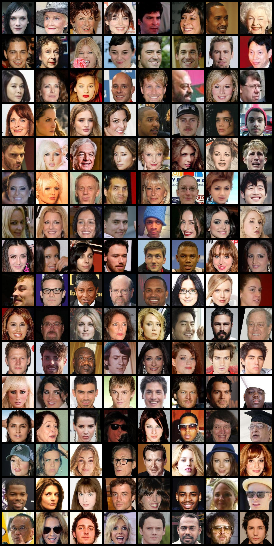

In [15]:
for X in train_loader:
    save_image(X,"./check.png")
    print(f"Shape of Batch Data: {X.shape}")
    break
Image.open("./check.png")

# Training

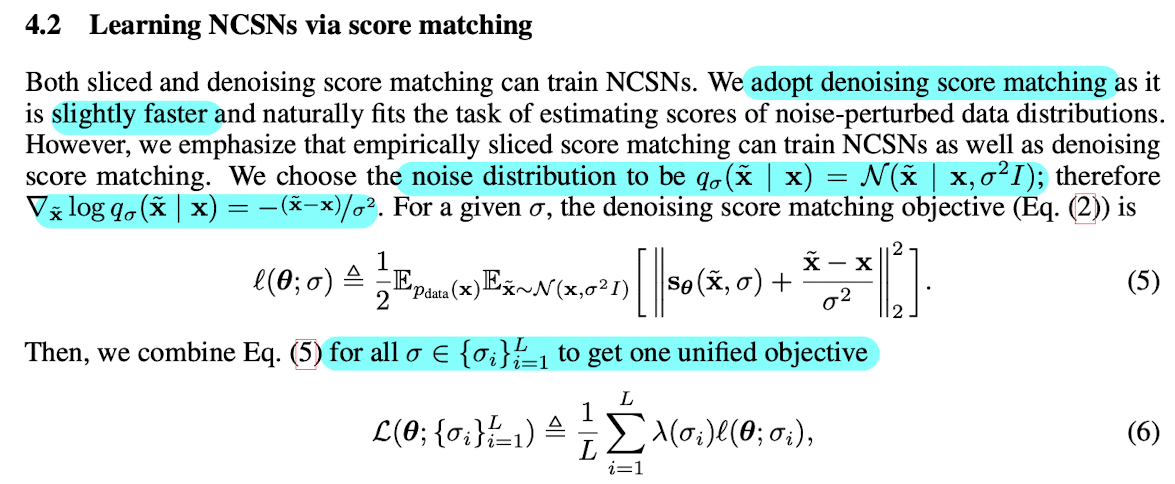

### anneal_denoising_score_estimation
- `score_model`: $s_{\theta}$
- `samples`: Input Images 
- `labels`: noise scale selection을 위한 index(0~L-1까지의 정수)
- `sigmas`: 여러 scale의 sigma. (sigma_1 > sigma_2 > ... > sigma_L)
- `perturbed_samples`: $q_{\sigma}(x) \triangleq \int p_{data}(t) N(x \ | \ t, \sigma^2I)\ dt$
- `target`: $\frac{(\tilde x-x)}{\sigma^2}$
- `scores`: $s_{\theta}(\tilde x, \sigma)$
- `loss`: $L(\theta; \{\sigma_{i} \}^L_{i=1}) \triangleq \frac{1}{L} \sum_{i=1}^L \lambda(\sigma_i) l(\theta, \sigma_i)$
    - $l(\theta ; \sigma) \triangleq \frac{1}{2}\mathbb E_{p_{data}(x)}\mathbb E_{\tilde x \sim N(x, \sigma^2I)}[|| s_{\theta}(\tilde x, \sigma) + \frac{(\tilde x-x)}{\sigma^2}||^2_2]$

In [16]:
# Loss
def anneal_denoising_score_estimation(score_model, samples, index, sigmas):
    
    used_sigmas = sigmas[index].view(samples.shape[0], 1,1,1) # (BatchSize, 1,1,1) ####
    perturbed_samples = samples + torch.randn_like(samples) * used_sigmas # 여러 scale의 가우시안 노이즈로 perturb data
    target = - (perturbed_samples - samples) / (used_sigmas ** 2)
    scores = score_model(perturbed_samples, index)
    target = target.view(target.shape[0], -1) # [BatchSize, 3x32x32]
    scores = scores.view(scores.shape[0], -1) # [BatchSize, 3x32x32]
    loss = 1 / 2. * ((scores - target) ** 2).sum(dim=-1) * used_sigmas.squeeze() ** 2 # [BatchSize]

    return loss.mean(dim=0)

In [18]:
# train

step = 0
running_loss = 0

sigmas = torch.tensor(
            np.exp(np.linspace(np.log(config.sigma_begin), np.log(config.sigma_end),
                               config.L))).float().to(config.device)

print('sigmas: ', sigmas) # sigma_1 > sigma_2 > ... > sigma_L

for epoch in range(config.n_epochs):
    for i, X in enumerate(train_loader):
        step += 1
        score_model.train()
        X = X.to(config.device)
        X = X / 256. * 255. + torch.rand_like(X) / 256. # Why we do this?
       
        noise_condition = torch.randint(0, config.L, (X.shape[0],), device=X.device) # Sigma index -> 노이즈간 거리가 동일하기 때문에, index를 condition으로 사용해도 무방
        loss = anneal_denoising_score_estimation(score_model, X, noise_condition, sigmas)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if step %50 == 0:
            print("Steps: {}/{}.. ".format(step, config.n_iters) +
                          "Training Loss: {:.5f}.. ".format(running_loss / step))                
        

        if step % 500 == 0:
            score_model.eval()
            try:
                test_X = next(test_iter)
            except StopIteration:
                test_iter = iter(test_loader)
                test_X = next(test_iter)
                
            test_X = test_X.to(config.device)
            test_X = test_X / 256. * 255. + torch.rand_like(test_X) / 256. # Also Why we need this?
            test_noise_condition = torch.randint(0, config.L, (X.shape[0],), device=X.device) 
            with torch.no_grad():
                test_loss = anneal_denoising_score_estimation(score_model, test_X, test_noise_condition, sigmas)
            print("Test Loss: {:.5f}.. ".format(test_loss))  
            torch.save(score_model.state_dict(), f"checkpoint_{str(step)}_step.tar")


sigmas:  tensor([1.0000, 0.5995, 0.3594, 0.2154, 0.1292, 0.0774, 0.0464, 0.0278, 0.0167,
        0.0100], device='cuda:0')
Steps: 50/200001.. Training Loss: 761.58164.. 
Steps: 100/200001.. Training Loss: 724.65014.. 
Steps: 150/200001.. Training Loss: 708.63210.. 
Steps: 200/200001.. Training Loss: 680.93281.. 
Steps: 250/200001.. Training Loss: 656.33038.. 
Steps: 300/200001.. Training Loss: 636.46408.. 
Steps: 350/200001.. Training Loss: 617.05837.. 
Steps: 400/200001.. Training Loss: 600.80530.. 
Steps: 450/200001.. Training Loss: 585.80429.. 
Steps: 500/200001.. Training Loss: 572.24980.. 
Test Loss: 434.50961.. 
Steps: 550/200001.. Training Loss: 561.20314.. 
Steps: 600/200001.. Training Loss: 550.49631.. 
Steps: 650/200001.. Training Loss: 540.70119.. 
Steps: 700/200001.. Training Loss: 531.72519.. 
Steps: 750/200001.. Training Loss: 523.22466.. 
Steps: 800/200001.. Training Loss: 515.54916.. 
Steps: 850/200001.. Training Loss: 508.60840.. 
Steps: 900/200001.. Training Loss: 502

KeyboardInterrupt: 

# Sampling (Inference)

<img src="https://ammunk.com/assets/img/ncsn/figs/algorithm.png" width="500">

### `anneal_Langevin_dynamics`
- `step_lr`: $\epsilon$
- `step_size`: $\alpha_i \leftarrow \epsilon \times \frac{\sigma_i^2}{\sigma_L^2}$
- `n_steps_each`: $T$
- `grad`: $s_{\theta}(\tilde x_{t-1}, \sigma_i) $
- `z`: $z_t \sim N(0,I)$

In [19]:
def anneal_Langevin_dynamics(x, score_model, sigmas, n_steps_each=100, step_lr=0.00002):
    images = []

    with torch.no_grad():
        
        # for i <- 1 to L do
        for i, sigma in tqdm(enumerate(sigmas), total=len(sigmas), desc='annealed Langevin dynamics sampling'):
            labels = torch.ones(x.shape[0], device=x.device) * i # sigma_i. [25]
            labels = labels.long()
            step_size = step_lr * (sigma / sigmas[-1]) ** 2 # alpha_i
            
            # for t <- 1 to T do
            for t in range(n_steps_each):
                images.append(torch.clamp(x, 0.0, 1.0).to('cpu')) # for visualization
                z = torch.randn_like(x) # Draw z_t ~ N(0,I)
                grad = score_model(x, labels) # score
                x = x + (0.5 * step_size * grad) + (np.sqrt(step_size) * z) # x_t <- x_{t-1} + ... + sqrt{alpha_i} * z_i

        return images # list: [T x sigma 길기=1000]

In [25]:
# 8x8 격자 크기로 annealed Langevin dynamics로 sigma_1~sigma_L까지, 각 노이즈 scale에서 T번의 step마다 sample된 결과를 시각화
grid_size = 8

score_model.eval()
sigmas = np.exp(np.linspace(np.log(config.sigma_begin), np.log(config.sigma_end), config.L))

samples = torch.rand(grid_size**2, 3, 32, 32, device=config.device) # Samples from Uniform distribution. [25, 3, 32, 32]

# Run Annealed Langevin dynamics
all_samples = anneal_Langevin_dynamics(samples, score_model, sigmas, config.T, config.step_lr) # Uniform distribution에서 추출한 Noise -> Annealed Langevin dynamics -> Image generation

annealed Langevin dynamics sampling: 100%|██████████| 10/10 [03:38<00:00, 21.89s/it]


In [26]:
# Save results
imgs = []
for i, sample in enumerate(tqdm(all_samples, total=len(all_samples), desc='saving images')):
    sample = sample.view(grid_size**2, 3, 32, 32)

    image_grid = make_grid(sample, nrow=grid_size)
    if i % 10 == 0:
        im = Image.fromarray(image_grid.mul_(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to('cpu', torch.uint8).numpy())
        imgs.append(im)

    save_image(image_grid, 'image_{}.png'.format(i), nrow=10)
    torch.save(sample, 'image_raw_{}.pth'.format(i))

imgs[0].save("movie.gif", save_all=True, append_images=imgs[1:], duration=1, loop=0)

saving images: 100%|██████████| 1000/1000 [00:23<00:00, 41.73it/s]


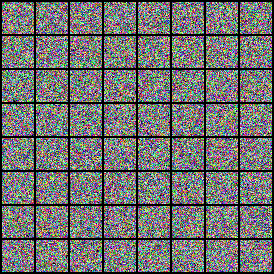

In [28]:
Image.open('movie.gif')